## Connect to ICW:

In [95]:
import cadspy
import numpy as np
import pandas as pd
from datetime import datetime as dt
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression


# diplay all rows and cols when using 'dataframe'.head() or 'dataframe'.tail()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



In [2]:
icw = cadspy.DatabaseConnection(system='ICW', user='n518899')

<br>

### Data

#### S19 Lounge Eligibility data

In [ ]:
# lounge eligibility data
query = """

sel * from LDB_SBOX_OR.HACKATHON_OPS_LOUNGE_ELIGIBILITY

"""

df_lounge_eligibility = icw.queryToDataframe(query)

# flight info data
query = """

select * from LDB_SBOX_OR.HACKATHON_OPS_FLIGHT_INFO

"""

df_flight_info = icw.queryToDataframe(query)

# country decode data
query = """

select * from LDB_SBOX_OR.HACKATHON_OPS_COUNTRY_DECODE

"""

df_country = icw.queryToDataframe(query)

# AC_type
query = """

select * from LDB_SBOX_OR.HACKATHON_OPS_AC_TYPE

"""

df_acft_typ = icw.queryToDataframe(query)

geo_query = """
SELECT 
	* 
FROM 
	REF_RAS_GEOGRAPHY RRG_O
	
WHERE
	RRG_O.STN_CD <> ''
"""

df_geo = icw.queryToDataframe(geo_query)

df_cap_city = pd.read_csv('https://raw.githubusercontent.com/icyrockcom/country-capitals/master/data/country-list.csv')


<br>

### Pre-processing

*Hint:* It is always worth checking the format of each of the columns in your dataframes before trying to do any work with them. To do so, you can make use of the `headers_and_first_row` function below.


In [6]:
def headers_and_first_row(df):
    '''
    print headers and first row of a df to deal with data types
    '''
    
    headers = df.columns
    first_row = []

    for col in headers:
        first_row.append(df[col][0])
    
    dictionary = dict( zip( headers, first_row) )

    return dictionary

# helper function

def dataframe_str_formatter(df):
    '''Strips all whitespace in string columns in DataFrame'''
    for col in df.columns:
        if isinstance(df[col][0],str):
            df[col] = df[col].str.strip()
        else:
            continue
    return df


In [7]:
# applying headers_and_first_row to df_lounge_eligibility
format_df = headers_and_first_row(df_lounge_eligibility)

# Note that some columns have blank spaces!
format_df

{'OPERATING_AIRLINE_CD': 'BA    ',
 'OPERATING_FLT_NO': 57,
 'GMT_UPLIFT_DT': datetime.date(2019, 6, 18),
 'UPLIFT_STN_CD': 'LHR   ',
 'DISCHARGE_STN_CD': 'JNB   ',
 'BOOKED_CABIN_CD': 'J ',
 'TRAVEL_CABIN_CD': 'J ',
 'BA_PAX_TIER': '',
 'ONEWORLD_TIER': 'EMER',
 'Lounge_eligibility_tier': 'Tier 2',
 'pax': 1}

In [8]:
# pre-processing code

df_lounge_eligibility = dataframe_str_formatter(df_lounge_eligibility)
df_lounge_eligibility['GMT_UPLIFT_DT'] = pd.to_datetime(df_lounge_eligibility['GMT_UPLIFT_DT'])


<br><br>

### df_flight_info pre-processing

In [9]:
format_df = headers_and_first_row(df_flight_info)

format_df

{'OPG_ALN_CD': 'BA    ',
 'OPG_FLT_NO': 548,
 'GMT_PLND_DEP_TS': Timestamp('2019-06-03 07:30:00'),
 'GMT_ACT_DEP_TS': Timestamp('2019-06-03 07:27:00'),
 'ACT_DEP_STN_CD': 'LHR   ',
 'ACT_DEP_TML_CD': '5 ',
 'PLND_ARR_STN_CD': 'FCO   ',
 'ACT_ARR_STN_CD': 'FCO   ',
 'IATA_AC_TYP_CD': '321   ',
 'ACT_AC_TYP_CD': 'V6  ',
 'ROUTE': 'LHRFCO      ',
 'COUNTRY_CD': 'IT    ',
 'COUNTRY_NM': 'Italy',
 'CORP_GEOG_CTRY_GRP_NM': 'MEDITERRANEAN',
 'CORP_GEOG_CONTINENT_NM': 'EUROPE EXC UK'}

In [10]:
# pre-processing code

df_flight_info = dataframe_str_formatter(df_flight_info)

# Need to convert to same date type for merge
df_flight_info['GMT_PLND_DEP_TS'] = pd.to_datetime(df_flight_info['GMT_PLND_DEP_TS'], format = '%Y-%m-%d')
df_flight_info['GMT_PLND_DEP'] = pd.to_datetime(df_flight_info['GMT_PLND_DEP_TS'].dt.date)

format_df = headers_and_first_row(df_flight_info)

format_df

{'OPG_ALN_CD': 'BA',
 'OPG_FLT_NO': 548,
 'GMT_PLND_DEP_TS': Timestamp('2019-06-03 07:30:00'),
 'GMT_ACT_DEP_TS': Timestamp('2019-06-03 07:27:00'),
 'ACT_DEP_STN_CD': 'LHR',
 'ACT_DEP_TML_CD': '5',
 'PLND_ARR_STN_CD': 'FCO',
 'ACT_ARR_STN_CD': 'FCO',
 'IATA_AC_TYP_CD': '321',
 'ACT_AC_TYP_CD': 'V6',
 'ROUTE': 'LHRFCO',
 'COUNTRY_CD': 'IT',
 'COUNTRY_NM': 'Italy',
 'CORP_GEOG_CTRY_GRP_NM': 'MEDITERRANEAN',
 'CORP_GEOG_CONTINENT_NM': 'EUROPE EXC UK',
 'GMT_PLND_DEP': Timestamp('2019-06-03 00:00:00')}

### df_country pre-processing

In [11]:
# show current format

format_df_country = headers_and_first_row(df_country)

format_df_country

# pre-processing code

df_country = dataframe_str_formatter(df_country)

format_df_country = headers_and_first_row(df_country)

format_df_country

{'ROUTE': 'LHRINV',
 'COUNTRY_CD': 'GB',
 'COUNTRY_NM': 'United Kingdom and Northern Ireland',
 'CORP_GEOG_CTRY_GRP_NM': 'UK',
 'CORP_GEOG_CONTINENT_NM': 'UK'}

### df_acft_type pre-processing

In [12]:
# show current format

format_df_aircraft = headers_and_first_row(df_acft_typ)

format_df_aircraft

# pre-processing code

df_acft_type = dataframe_str_formatter(df_acft_typ)

format_df_aircraft = headers_and_first_row(df_acft_typ)

format_df_aircraft

{'IATA_AC_TYP_CD': '320',
 'ACT_AC_TYP_CD': 'A3',
 'WB_NB_CAT': 'NB',
 'FIRST_SEATS_QTY': 0,
 'CLUB_SEATS_QTY': 24,
 'PREM_ECONOMY_SEATS_QTY': 0,
 'ECONOMY_SEATS_QTY': 132}

In [13]:
format_df_geo = headers_and_first_row(df_geo)

format_df_geo

# pre-processing code

df_geo = dataframe_str_formatter(df_geo)

In [14]:
# Example

# joining df_lounge_eligibility and df_flight_info

df_lounge_elig_flight_info = pd.merge(df_lounge_eligibility,# left table
                                     df_flight_info, # right table
                                     left_on = ['GMT_UPLIFT_DT','OPERATING_FLT_NO','UPLIFT_STN_CD','DISCHARGE_STN_CD'], # left on? e.g. which columns from the left table are you joining on to?
                                     right_on = ['GMT_PLND_DEP','OPG_FLT_NO','ACT_DEP_STN_CD','ACT_ARR_STN_CD'], # right on? # left on? e.g. which columns from the right table are you joining on to?
                                     how = "left" # how? e.g. left, right, inner,etc
                                     )

print('Old Shape: {}'.format(df_lounge_eligibility.shape))
print('New Shape: {}'.format(df_lounge_elig_flight_info.shape))

Old Shape: (973878, 11)
New Shape: (973878, 27)


### Check Join has worked correctly by looking at some rows and countings null where join may not have worked

In [15]:
# your code here!

df_lounge_country_flight = pd.merge(df_lounge_elig_flight_info,
                                   df_country,
                                   on = 'ROUTE',
                                   how = 'left'
                                   )

print('Old Shape: {}'.format(df_lounge_elig_flight_info.shape))
print('New Shape: {}'.format(df_lounge_country_flight.shape))

Old Shape: (973878, 27)
New Shape: (973878, 31)


In [16]:
df_lounge_country_geo = pd.merge(df_lounge_country_flight,
                                   df_geo,
                                   left_on = 'DISCHARGE_STN_CD',
                                   right_on = 'STN_CD',
                                   how = 'left'
                                   )

print('Old Shape: {}'.format(df_lounge_country_flight.shape))
print('New Shape: {}'.format(df_lounge_country_geo.shape))

Old Shape: (973878, 31)
New Shape: (973878, 48)


In [17]:
df_pen = pd.merge(df_lounge_country_geo,
                   df_acft_typ,
                   on = ['IATA_AC_TYP_CD','ACT_AC_TYP_CD'],
                   how = 'left'

                   )

print('Old Shape: {}'.format(df_lounge_country_flight.shape))
print('New Shape: {}'.format(df_pen.shape))

Old Shape: (973878, 31)
New Shape: (973878, 53)


In [18]:
df_final = pd.merge(df_pen,
                   df_cap_city,
                   left_on = ['CITY_NM'],
                   right_on = ['capital'],
                   how = 'left'
                   )

print('Old Shape: {}'.format(df_pen.shape))
print('New Shape: {}'.format(df_final.shape))

Old Shape: (973878, 53)
New Shape: (973878, 56)


<br><br><br>

In [ ]:
#--------------------------------
#
# Your turn!!!
#
#--------------------------------

<u>What level of granularity do you use?</u>

This project wants to understand what characteristics of a flight help us get a better picture of the lounge eligibility profiles.
Things I want to consider:
- Time of flight (Morning, Afternoon, Evening) or maybe even by hour
- Destination as this determines the passenger profile, different countries/regions have more premium passengers potentially
- Short Haul/Medium Haul/Long Haul 
- Month of Flight
- City Route Flag
- Weekday/Weekend 
- Business Route indicator?


<u>General Thoughts:</u>

Destination:
- Routes are too granular as if we have new routes in the future we wouldn't be able to estimate
- Countries could also be granular if we develop new routes to countries
- Region may be suited as we currently fly to all regions
- We need to think how to consider how certain countries within a region may have higher premium loads vs others

<u>What metric do you use to come up with Lounge eligibility profiles?</u>
- ... (your answer here)

## Key Functions

#### Proportion Table Function

In [47]:
df_final.sample(10)

,OPERATING_AIRLINE_CD,OPERATING_FLT_NO,GMT_UPLIFT_DT,UPLIFT_STN_CD,DISCHARGE_STN_CD,BOOKED_CABIN_CD,TRAVEL_CABIN_CD,BA_PAX_TIER,ONEWORLD_TIER,Lounge_eligibility_tier,pax,OPG_ALN_CD,OPG_FLT_NO,GMT_PLND_DEP_TS,GMT_ACT_DEP_TS,ACT_DEP_STN_CD,ACT_DEP_TML_CD,PLND_ARR_STN_CD,ACT_ARR_STN_CD,IATA_AC_TYP_CD,ACT_AC_TYP_CD,ROUTE,COUNTRY_CD_x,COUNTRY_NM_x,CORP_GEOG_CTRY_GRP_NM_x,CORP_GEOG_CONTINENT_NM_x,GMT_PLND_DEP,COUNTRY_CD_y,COUNTRY_NM_y,CORP_GEOG_CTRY_GRP_NM_y,CORP_GEOG_CONTINENT_NM_y,REGION_NM,REGION_CD,SUB_REGION_NM,SUB_REGION_CD,CTRY_NM,CTRY_CD,SUB_CTRY_NM,SUB_CTRY_CD,CITY_NM,CITY_CD,STN_NM,STN_CD,REG_NM,REG_CD,SUB_REG_NM,SUB_REG_CD,ICW_TX_PD,WB_NB_CAT,FIRST_SEATS_QTY,CLUB_SEATS_QTY,PREM_ECONOMY_SEATS_QTY,ECONOMY_SEATS_QTY,country,capital,type
821659,BA,293,2019-08-06,LHR,IAD,W,W,Silver,SAPP,Tier 3,1,BA,293.0,2019-08-06 16:10:00,2019-08-06 16:12:00,LHR,5,IAD,IAD,777,V7,LHRIAD,US,United States,USA,NORTH AMERICA,2019-08-06,US,United States,USA,NORTH AMERICA,N America,2,US Territories,UT,USA,US,None,None,Washington,WAS,Washington - Dulles,IAD,N America,2,US Territories,UT,"2017-02-28 13:42:06.000000,9999-12-31 23:59:59...",WB,14.0,48.0,40.0,124.0,NaN,NaN,NaN
1630,BA,638,2019-07-28,LHR,ATH,C,C,,,Tier 3,37,BA,638.0,2019-07-28 05:45:00,2019-07-28 05:43:00,LHR,5,ATH,ATH,32N,N3,LHRATH,GR,Greece,MEDITERRANEAN,EUROPE EXC UK,2019-07-28,GR,Greece,MEDITERRANEAN,EUROPE EXC UK,Europe,1,S Europe,SE,Greece,GR,None,None,Athens,ATH,Athens,ATH,Europe,1,S Europe,SE,"2017-02-28 13:42:06.000000,9999-12-31 23:59:59...",NB,0.0,20.0,0.0,150.0,Greece,Athens,countryCapital
713067,BA,716,2019-05-31,LHR,ZRH,C,C,,,Tier 3,16,BA,716.0,2019-05-31 13:45:00,2019-05-31 13:48:00,LHR,5,ZRH,ZRH,321,V6,LHRZRH,CH,Switzerland,WEST EUROPE,EUROPE EXC UK,2019-05-31,CH,Switzerland,WEST EUROPE,EUROPE EXC UK,Europe,1,W Europe,WE,Switzerland,CH,None,None,Zurich,ZRH,Zurich,ZRH,Europe,1,W Europe,WE,"2017-02-28 13:42:06.000000,9999-12-31 23:59:59...",NB,0.0,38.0,0.0,160.0,NaN,NaN,NaN
714529,BA,183,2019-08-06,LHR,JFK,J,J,,SAPP,Tier 3,3,BA,183.0,2019-08-06 18:50:00,2019-08-06 19:11:00,LHR,5,JFK,JFK,744,S4,LHRJFK,US,United States,USA,NORTH AMERICA,2019-08-06,US,United States,USA,NORTH AMERICA,N America,2,US Territories,UT,USA,US,None,None,New York,NYC,New York-John F Kennedy,JFK,N America,2,US Territories,UT,"2017-02-28 13:42:06.000000,9999-12-31 23:59:59...",WB,14.0,86.0,30.0,145.0,NaN,NaN,NaN
23724,BA,1460,2019-08-15,LHR,EDI,M,M,Gold,EMER,Tier 2,6,BA,1460.0,2019-08-15 19:55:00,2019-08-15 19:57:00,LHR,5,EDI,EDI,32N,N3,LHREDI,GB,United Kingdom and Northern Ireland,UK,UK,2019-08-15,GB,United Kingdom and Northern Ireland,UK,UK,Europe,1,W Europe,WE,UK,GB,Scotland,SC,Edinburgh,EDI,Edinburgh,EDI,Europe,1,W Europe,WE,"2017-02-28 13:42:06.000000,9999-12-31 23:59:59...",NB,0.0,20.0,0.0,150.0,Scotland,Edinburgh,countryCapital
399286,BA,848,2019-06-15,LHR,ZAG,M,C,,,Tier 3,2,BA,848.0,2019-06-15 08:10:00,2019-06-15 08:19:00,LHR,5,ZAG,ZAG,319,A4,LHRZAG,HR,Croatia,EASTERN EUROPE,EUROPE EXC UK,2019-06-15,HR,Croatia,EASTERN EUROPE,EUROPE EXC UK,Europe,1,E Europe,EE,Croatia,HR,None,None,Zagreb,ZAG,Zagreb Franjo Tudman,ZAG,Europe,1,E Europe,EE,"2018-05-05 05:06:23.000000,9999-12-31 23:59:59...",NB,0.0,16.0,0.0,119.0,Croatia,Zagreb,countryCapital
150517,BA,422,2019-06-23,LHR,VLC,M,M,,SAPP,Tier 3,2,BA,422.0,2019-06-23 15:45:00,2019-06-23 15:54:00,LHR,5,VLC,VLC,32N,N3,LHRVLC,ES,Spain,WEST EUROPE,EUROPE EXC UK,2019-06-23,ES,Spain,WEST EUROPE,EUROPE EXC UK,Europe,1,W Europe,WE,Spain,ES,Peninsula,PE,Valencia,VLC,Valencia,VLC,Europe,1,W Europe,WE,"2017-02-28 13:42:06.000000,9999-12-31 23:59:59...",NB,0.0,20.0,0.0,150.0,NaN,NaN,NaN
546600,BA,936,2019-04-14,LHR,DUS,C,C,,,Tier 3,4,BA,936.0,2019-04-14 06:35:00,2019-04-14 06:34:00,LHR,5,DUS,DUS,319,A4,LHRDUS,DE,Germany,WEST EUROPE,EUROPE EXC UK,2019-04-14,DE,Germany,WEST EUROPE,EUROPE EXC UK,Europe,1,W Europe,WE,Germany,DE,None,None,Duesseldorf,DUS,Duesseldorf,DUS,Europe,1,W Europe,WE,"2021-04-09 05:05:58.000000,9999-12-31 23:59:59...",NB,0.0,16.0,0.0,119.0,NaN,NaN,

In [19]:
def tier_proportions(features, df_fin):
    
    '''A function to build our the proportion of customers eligible for lounge based on features inputted'''

    tier_col = 'Lounge_eligibility_tier'
    
    # Create group by parameters
    groupby_list = features[:]
    groupby_list.append(tier_col)

    # Get total eligible by features and tier
    df_grouped = df_fin.groupby(groupby_list).agg({'pax':'sum'})

    # Add total amount for features excluding tier to get breakdown
    df_grouped['total_pax_features'] = df_grouped.groupby(features)['pax'].transform('sum')

    # proportion elgible 
    df_grouped['proportion'] = (df_grouped['pax'] / df_grouped['total_pax_features']) * 100
    df_grouped['proportion'] = df_grouped['proportion'].map('{:,.1f}%'.format)

    # reset index
    df_grouped.reset_index(inplace = True)

    # remove not eligible passengers
    df_grouped = df_grouped[df_grouped[tier_col] != 'Not eligible']

    # reshape data required for Ops Team
    df = df_grouped.pivot(index = features, columns = tier_col, values = 'proportion')
    
    return df


<br>

Please save your final lookup table below in the form of a pandas dataframe. It must contain the categories you have come up with as rows, and the Tier 1, Tier 2, and Tier 3 percentage of costumers as columns.

#### Evaluation Function

In [22]:
# Build out the daily passengers for each flight

def feature_pax_2019(features, df):
    
    '''Computes the passengers who travelled by features and flight number and day'''
    
    eval_list = features[:]
    group_features = ['GMT_UPLIFT_DT','OPERATING_FLT_NO']
    prop_features = group_features[:]
    prop_features.extend(eval_list)
    df_flight_sum = df_final.groupby(prop_features)['pax'].sum().reset_index()
    return df_flight_sum, group_features
    
def proportion_formatter(df):
    
    '''Simple function to reformat the tier eligibility table for evaluation joins'''
    
    # format the proportions for the join
    df_proportions = df.stack().reset_index()

    # rename proportion column
    df_proportions = df_proportions.rename({0:'Proportions'}, axis = 1)
    
    return df_proportions

def flight_tier_forecast(df_prop, df_feat, feat_list):
    
    '''Forecasts the number of passengers in each tier for each flight'''
    
    # join the two

    df_total = pd.merge(df_feat, df_prop, how = 'inner', on = feat_list)

    # calculate proportion of each tier in each flight
    df_total['Proportion Numeric'] = df_total['Proportions'].str.replace('%','').astype(float) / 100
    df_total['tier_pax'] = df_total['pax'] * df_total['Proportion Numeric']
    df_total['tier_pax'] = df_total['tier_pax'].values.round()

    return df_total

def eval_table(df_final, df_tot, group_features):

    '''Function to create the evaluation table which compares forecast vs actual'''
    
    tier = 'Lounge_eligibility_tier'

    tier_features = group_features[:]
    tier_features.append(tier)

    df_tier = df_final.groupby(by = tier_features)['pax'].sum().reset_index()
    df_eval = pd.merge(df_tier, df_tot, how = 'inner', on = tier_features)
    
    return  df_eval

def rmse(df_eval):
    
    '''Returns the Root Mean Squared Error of our prediction'''
    
    df_eval['sqrd_resid'] = (df_eval['pax_x'] - df_eval['tier_pax']) ** 2
    std = np.sqrt(df_eval['sqrd_resid'].sum() / df_eval.shape[0])
    
    return std

def evaluation(feat, df_fin, df_test):
    
    '''Function which returns the RMSE of the forecast'''
    
    df_feat, grp_feat = feature_pax_2019(feat, df_fin)
    df_prop_feat = proportion_formatter(df_test)
    df_total = flight_tier_forecast(df_prop_feat, df_feat, feat)
    df_eval = eval_table(df_fin, df_total, grp_feat)
    std = rmse(df_eval)
    return std, df_eval
    
    

#### Combination Function

In [23]:
def feature_evaluation(feat, df):
    
    df_test = tier_proportions(feat, df)
    result, df_result = evaluation(feat, df, df_test)
    return result, df_result
    
def feature_combination(features):
    
    '''Simple function which returns every possible combination of features'''
    
    nbr_features = len(features)
    feature_comb_list = []
    for nbr in range(1,nbr_features + 1):
        stage_comb = [list(comb) for comb in combinations(features, nbr)]
        feature_comb_list.extend(stage_comb)
        
    return feature_comb_list
    
def combination_evaluation(features, df):
    
    '''A function to test every combination and evaluate its performance'''
    
    results = []
    test_features = feature_combination(features)
    
    # loop through every combination of features and test result
    for feat_comb in test_features:
        rmse, df = feature_evaluation(feat_comb, df)
        results.append([feat_comb,rmse])
        
    # create dataframe of results
    df_result = pd.DataFrame(results, columns = ['feature_combination','RMSE'])
    df_result = df_result.sort_values('RMSE', ascending = True)
    
    return df_result

## Data exploration

In [ ]:
df_final.head()

Things to explore:
- How does true proportions change by region
- Where the errors lie, specific regions or any other valuable features we can build
- Do certain countries have first class and impact on prediction


Features to build:


In [18]:
# City Flag
df_final['capital_city_flag'] = df_final['capital'].apply(lambda x: 'N' if pd.isnull(x) else 'Y')

In [31]:
features = ['CORP_GEOG_CTRY_GRP_NM_x','time_cat','season','weekend_flag','WB_NB_CAT','capital_city_flag']
features = ['CORP_GEOG_CTRY_GRP_NM_x']

#final_table = combination_evaluation(features, df_final)
result, df_res = feature_evaluation(features, df_final)

In [32]:
result

8.598721191698077

In [31]:
df_res.head()

,GMT_UPLIFT_DT,OPERATING_FLT_NO,Lounge_eligibility_tier,pax_x,CORP_GEOG_CTRY_GRP_NM_x,pax_y,Proportions,Proportion Numeric,tier_pax,sqrd_resid
0,2019-03-31,5,Tier 1,10,JAPAN,241,4.9%,0.049,12.0,4.0
1,2019-03-31,5,Tier 2,15,JAPAN,241,5.3%,0.053,13.0,4.0
2,2019-03-31,5,Tier 3,47,JAPAN,241,20.0%,0.200,48.0,1.0
3,2019-03-31,7,Tier 1,16,JAPAN,300,4.9%,0.049,15.0,1.0
4,2019-03-31,7,Tier 2,20,JAPAN,300,5.3%,0.053,16.0,16.0


In [62]:
# create sorted data frame
df_sorted = df_res.sort_values('sqrd_resid', ascending = False)

# create daily
df_daily = df_sorted.groupby(['GMT_UPLIFT_DT','Lounge_eligibility_tier'])[['pax_x','tier_pax']].sum().reset_index()



Things to do:

- Trial machine learning to predict the number of passengers in each tier
- EDA of different feature to see proportion in tiers by feature


Can we predict the number of passengers in each tier using attributes of the flight

In [33]:
df_final.head(2)

,OPERATING_AIRLINE_CD,OPERATING_FLT_NO,GMT_UPLIFT_DT,UPLIFT_STN_CD,DISCHARGE_STN_CD,BOOKED_CABIN_CD,TRAVEL_CABIN_CD,BA_PAX_TIER,ONEWORLD_TIER,Lounge_eligibility_tier,pax,OPG_ALN_CD,OPG_FLT_NO,GMT_PLND_DEP_TS,GMT_ACT_DEP_TS,ACT_DEP_STN_CD,ACT_DEP_TML_CD,PLND_ARR_STN_CD,ACT_ARR_STN_CD,IATA_AC_TYP_CD,ACT_AC_TYP_CD,ROUTE,COUNTRY_CD_x,COUNTRY_NM_x,CORP_GEOG_CTRY_GRP_NM_x,CORP_GEOG_CONTINENT_NM_x,GMT_PLND_DEP,COUNTRY_CD_y,COUNTRY_NM_y,CORP_GEOG_CTRY_GRP_NM_y,CORP_GEOG_CONTINENT_NM_y,REGION_NM,REGION_CD,SUB_REGION_NM,SUB_REGION_CD,CTRY_NM,CTRY_CD,SUB_CTRY_NM,SUB_CTRY_CD,CITY_NM,CITY_CD,STN_NM,STN_CD,REG_NM,REG_CD,SUB_REG_NM,SUB_REG_CD,ICW_TX_PD,WB_NB_CAT,FIRST_SEATS_QTY,CLUB_SEATS_QTY,PREM_ECONOMY_SEATS_QTY,ECONOMY_SEATS_QTY,country,capital,type
0,BA,57,2019-06-18,LHR,JNB,J,J,,EMER,Tier 2,1,BA,57.0,2019-06-18 20:25:00,2019-06-18 20:22:00,LHR,5,JNB,JNB,744,S4,LHRJNB,ZA,South Africa,SOUTHERN AFRICA,AFRICA,2019-06-18,ZA,South Africa,SOUTHERN AFRICA,AFRICA,AMESA,3,Africa,AF,South Africa,ZA,None,None,Johannesburg,JNB,Johannesburg International,JNB,AMESA,3,Africa,AF,"2017-02-28 13:42:06.000000,9999-12-31 23:59:59...",WB,14.0,86.0,30.0,145.0,NaN,NaN,NaN
1,BA,247,2019-06-29,LHR,GRU,J,J,Gold,EMER,Tier 2,1,BA,247.0,2019-06-29 21:25:00,2019-06-29 21:39:00,LHR,5,GRU,GRU,77W,G7,LHRGRU,BR,Brazil,SOUTH AMERICA,SOUTH AMERICA INC CARIBBEAN,2019-06-29,BR,Brazil,SOUTH AMERICA,SOUTH AMERICA INC CARIBBEAN,LACAR,4,S America,SM,Brazil,BR,None,None,Sao Paulo,SAO,Sao Paulo - Guarulhos,GRU,LACAR,4,S America,SM,"2017-02-28 13:42:06.000000,9999-12-31 23:59:59...",WB,14.0,56.0,44.0,183.0,NaN,NaN,NaN


In [35]:
df_test = df_final.groupby(by = ['OPERATING_AIRLINE_CD','OPERATING_FLT_NO','GMT_UPLIFT_DT','GMT_PLND_DEP_TS','GMT_ACT_DEP_TS','UPLIFT_STN_CD','DISCHARGE_STN_CD',
               'CORP_GEOG_CTRY_GRP_NM_x','REGION_NM','WB_NB_CAT','IATA_AC_TYP_CD','capital','FIRST_SEATS_QTY','CLUB_SEATS_QTY',
               'PREM_ECONOMY_SEATS_QTY','ECONOMY_SEATS_QTY','capital'])['pax'].sum()

Lets explore the data to see which regions typically have more flights with tier 1 passengers

There are alot of flights with in Europe with Tier 1 passengers, lets see as a proportion of total flights

In [50]:
# build dataframe at flight level

flight_feat = ['OPERATING_AIRLINE_CD','OPERATING_FLT_NO','GMT_UPLIFT_DT','GMT_PLND_DEP_TS','GMT_ACT_DEP_TS','UPLIFT_STN_CD','DISCHARGE_STN_CD',
               'CORP_GEOG_CTRY_GRP_NM_x','REGION_NM','WB_NB_CAT','IATA_AC_TYP_CD','capital','FIRST_SEATS_QTY','CLUB_SEATS_QTY',
               'PREM_ECONOMY_SEATS_QTY','ECONOMY_SEATS_QTY','COUNTRY_NM_x']


# Build dataframe with a row for each flight
df_flight = df_final.groupby(flight_feat)['pax'].sum().reset_index()
df_flight = df_flight.rename({'pax':'total_pax'}, axis = 1)

# Build dataframe of number of passengers on each tier
tier_feat = flight_feat[:]
tier_feat.append('Lounge_eligibility_tier')
df_tier = df_final.groupby(tier_feat)['pax'].sum().reset_index()



In [51]:
# Add in the number of passengers in each tier
test = flight_feat[:]
test.append('pax')
tiers = list(df_final['Lounge_eligibility_tier'].unique())


for tier in tiers:
    df_flight = pd.merge(df_flight, df_tier[df_tier['Lounge_eligibility_tier'] == tier][test], how = 'left', on = flight_feat)
    df_flight = df_flight.rename({'pax': tier + '_pax'}, axis = 1)



Features to build:

- NB/WB w/wo first
- Haul
- Capital City
- Day of Week
- Domestic

In [52]:
df_flight.head(2)

,OPERATING_AIRLINE_CD,OPERATING_FLT_NO,GMT_UPLIFT_DT,GMT_PLND_DEP_TS,GMT_ACT_DEP_TS,UPLIFT_STN_CD,DISCHARGE_STN_CD,CORP_GEOG_CTRY_GRP_NM_x,REGION_NM,WB_NB_CAT,IATA_AC_TYP_CD,capital,FIRST_SEATS_QTY,CLUB_SEATS_QTY,PREM_ECONOMY_SEATS_QTY,ECONOMY_SEATS_QTY,COUNTRY_NM_x,total_pax,Tier 2_pax,Tier 3_pax,Tier 1_pax,Not eligible_pax
0,BA,5,2019-03-31,2019-03-31 14:45:00,2019-03-31 14:51:00,LHR,NRT,JAPAN,Asia Pacific,WB,789,Tokyo,8.0,42.0,39.0,127.0,Japan,241,15.0,47.0,10.0,169.0
1,BA,5,2019-04-01,2019-04-01 14:45:00,2019-04-01 14:54:00,LHR,NRT,JAPAN,Asia Pacific,WB,789,Tokyo,8.0,42.0,39.0,127.0,Japan,225,7.0,43.0,13.0,162.0


In [79]:
# Feature Creation

# Time of the day 
df_flight['time_cat'] = pd.cut(df_flight['GMT_PLND_DEP_TS'].dt.hour, bins = [0,5,12,17,21,24], labels = ['Night','Morning','Afternoon','Evening','Night'], include_lowest = True, ordered = False)

# Season
df_flight['season'] = pd.cut(df_flight['GMT_PLND_DEP_TS'].dt.month, bins = [0,2,5,8,11,12], labels = ['Winter','Spring','Summer','Autumn','Winter'], include_lowest = True, ordered = False)

# Weekend Flag
df_flight['weekend_flag'] = df_flight['GMT_PLND_DEP_TS'].dt.dayofweek.apply(lambda x: 'Y' if x > 4 else 'N' )

# Month
df_flight['month'] = df_flight['GMT_PLND_DEP_TS'].dt.month

# Day of Week
df_flight['day_of_week'] = df_flight['GMT_PLND_DEP_TS'].dt.dayofweek

# NB/WB w/wo
df_flight['NB_WB_NEW'] = np.where(df_flight['FIRST_SEATS_QTY'] > 0, 'WB w F', np.where(df_flight['WB_NB_CAT'] == 'WB', 'WB w/o', 'NB'))

# Domestic Flag
df_flight['Domestic Flag'] = df_flight['COUNTRY_NM_x'].apply(lambda x: 'Y' if x == 'United Kingdom and Northern Ireland' else 'N')

# Total number of seats

df_flight['Total Seats'] = df_flight['FIRST_SEATS_QTY'] + df_flight['CLUB_SEATS_QTY'] + df_flight['PREM_ECONOMY_SEATS_QTY'] + df_flight['ECONOMY_SEATS_QTY']

In [80]:
df_flight.head(2)

,OPERATING_AIRLINE_CD,OPERATING_FLT_NO,GMT_UPLIFT_DT,GMT_PLND_DEP_TS,GMT_ACT_DEP_TS,UPLIFT_STN_CD,DISCHARGE_STN_CD,CORP_GEOG_CTRY_GRP_NM_x,REGION_NM,WB_NB_CAT,IATA_AC_TYP_CD,capital,FIRST_SEATS_QTY,CLUB_SEATS_QTY,PREM_ECONOMY_SEATS_QTY,ECONOMY_SEATS_QTY,COUNTRY_NM_x,total_pax,Tier 2_pax,Tier 3_pax,Tier 1_pax,Not eligible_pax,time_cat,season,weekend_flag,month,day_of_week,NB_WB_NEW,Domestic Flag,Total Seats
0,BA,5,2019-03-31,2019-03-31 14:45:00,2019-03-31 14:51:00,LHR,NRT,JAPAN,Asia Pacific,WB,789,Tokyo,8.0,42.0,39.0,127.0,Japan,241,15.0,47.0,10.0,169.0,Afternoon,Spring,Y,3,6,WB w F,N,216.0
1,BA,5,2019-04-01,2019-04-01 14:45:00,2019-04-01 14:54:00,LHR,NRT,JAPAN,Asia Pacific,WB,789,Tokyo,8.0,42.0,39.0,127.0,Japan,225,7.0,43.0,13.0,162.0,Afternoon,Spring,N,4,0,WB w F,N,216.0


Our goal is to understand what attributes about flights will help us estimate the % of passengers in each tier of the lounge.

Lets uncover some insights from the flight data.

In [23]:
print('Total Number of flights: {}'.format(df_flight.shape[0]))

Total Number of flights: 26567


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


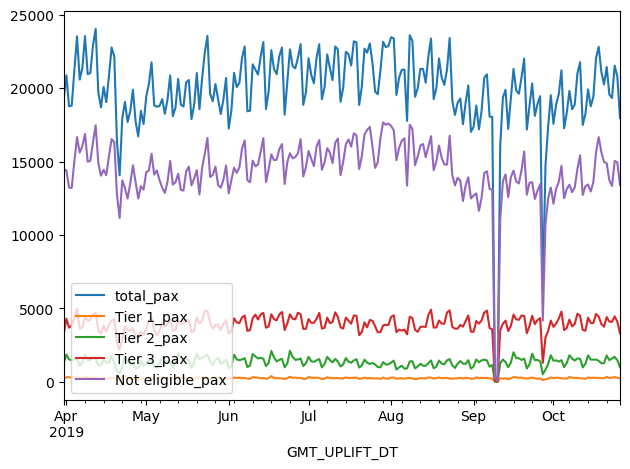

In [76]:
# Number of passengers by day

df_daily = df_flight.groupby('GMT_UPLIFT_DT')['total_pax','Tier 1_pax','Tier 2_pax','Tier 3_pax','Not eligible_pax'].sum()


df_daily.plot()
plt.tight_layout()
plt.legend(loc = "lower left")
plt.show()

Daily passenger numbers for each tier don't change much.

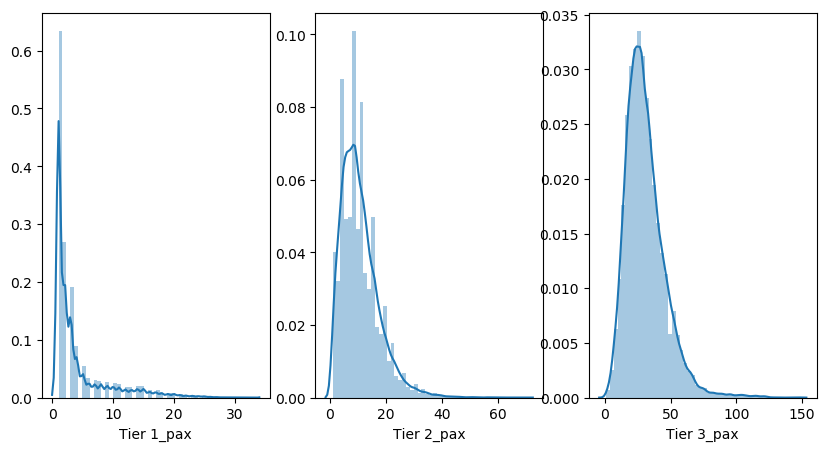

In [93]:
fig, axes = plt.subplots(1,3, figsize = (10,5))
sns.distplot(df_flight['Tier 1_pax'], ax = axes[0])
sns.distplot(df_flight['Tier 2_pax'],ax = axes[1])
sns.distplot(df_flight['Tier 3_pax'],ax = axes[2])
plt.show()

We have built a discrete frequency distribution which shows us the number of passengers by tier and the counts.

All distributions are right skewed at different levels, tier 1 being th emost and tier 3 being the least.

The majority of flights have less than 5 tier 1 passengers, between 0 and 20 tier 2 and between 0 and 50 tier 3 passengers



## Tier 1 Relationship with Categorical Variables

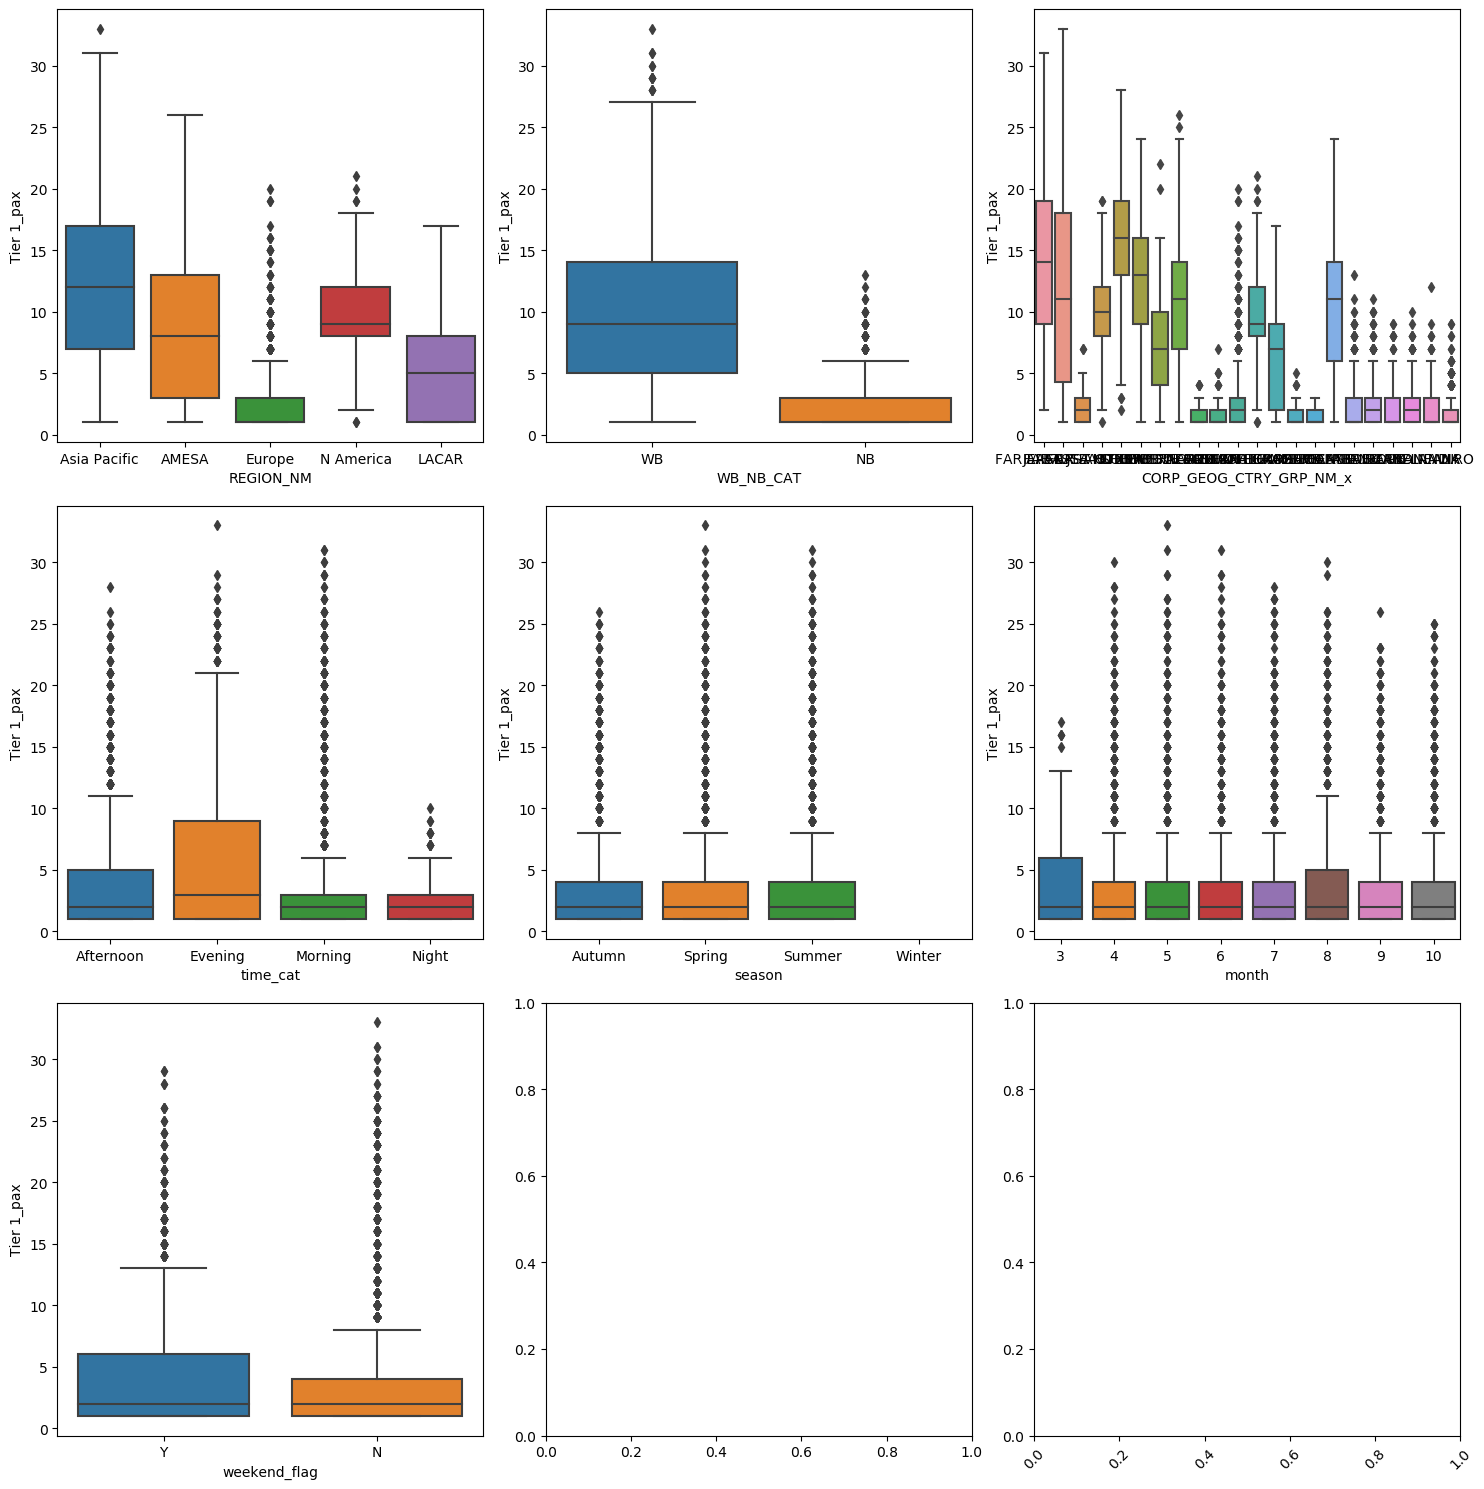

In [31]:
def boxplot_cat(cats, df, target):
    
    '''Builds box plots that compare our target variable tier pax by categorical variable'''
    
    nbr_cat = len(cats)
    columns = 3
    if (nbr_cat % columns) == 0:
        nbr_rows = nbr_cat // columns
    else:
        nbr_rows = nbr_cat // columns + 1

    
    # Build space for plots
    fig, axes = plt.subplots(nbr_rows, columns, figsize = (15,5 * nbr_rows))
    
    # Loop through each cat
    row = 0
    column = 0
    
    for cat in cats:
        if nbr_rows > 1:
            sns.boxplot(x = cat, y = target, data = df, ax = axes[row, column])
        else:
            sns.boxplot(x = cat, y = target, data = df, ax = axes[column])
        
        if column == 0 or column == 1:
            column += 1
        else:
            column = 0
            row += 1
            
    plt.xticks(rotation = 45)       
    plt.tight_layout()
    plt.show()
    
cat_feat = ['REGION_NM','WB_NB_CAT','CORP_GEOG_CTRY_GRP_NM_x','time_cat','season','month','weekend_flag']
boxplot_cat(cat_feat, df_flight, 'Tier 1_pax')
    

On initial exploration of categorical features vs tier 1 passengers we can see the follwing:

- Region is a useful predictor of the number of tier 1 passengers and this could be a proxy of long haul vs short haul as europe is the closest region and won't have first class on board.
- Asia pacific seems to have the highest number of tier 1 pax on average
- WB_NB_CAT is a useful predictor as this determines again the haul usually as WB are used on long haul and more likely to have first class passengers
- Time cat seems to show some small relationship where evening flights having more tier 1 passengers vs other periods of the day, this could be due to more long haul flights departing in the evening with first class availability.

## Tier 2 Relationship with Categorical Variables

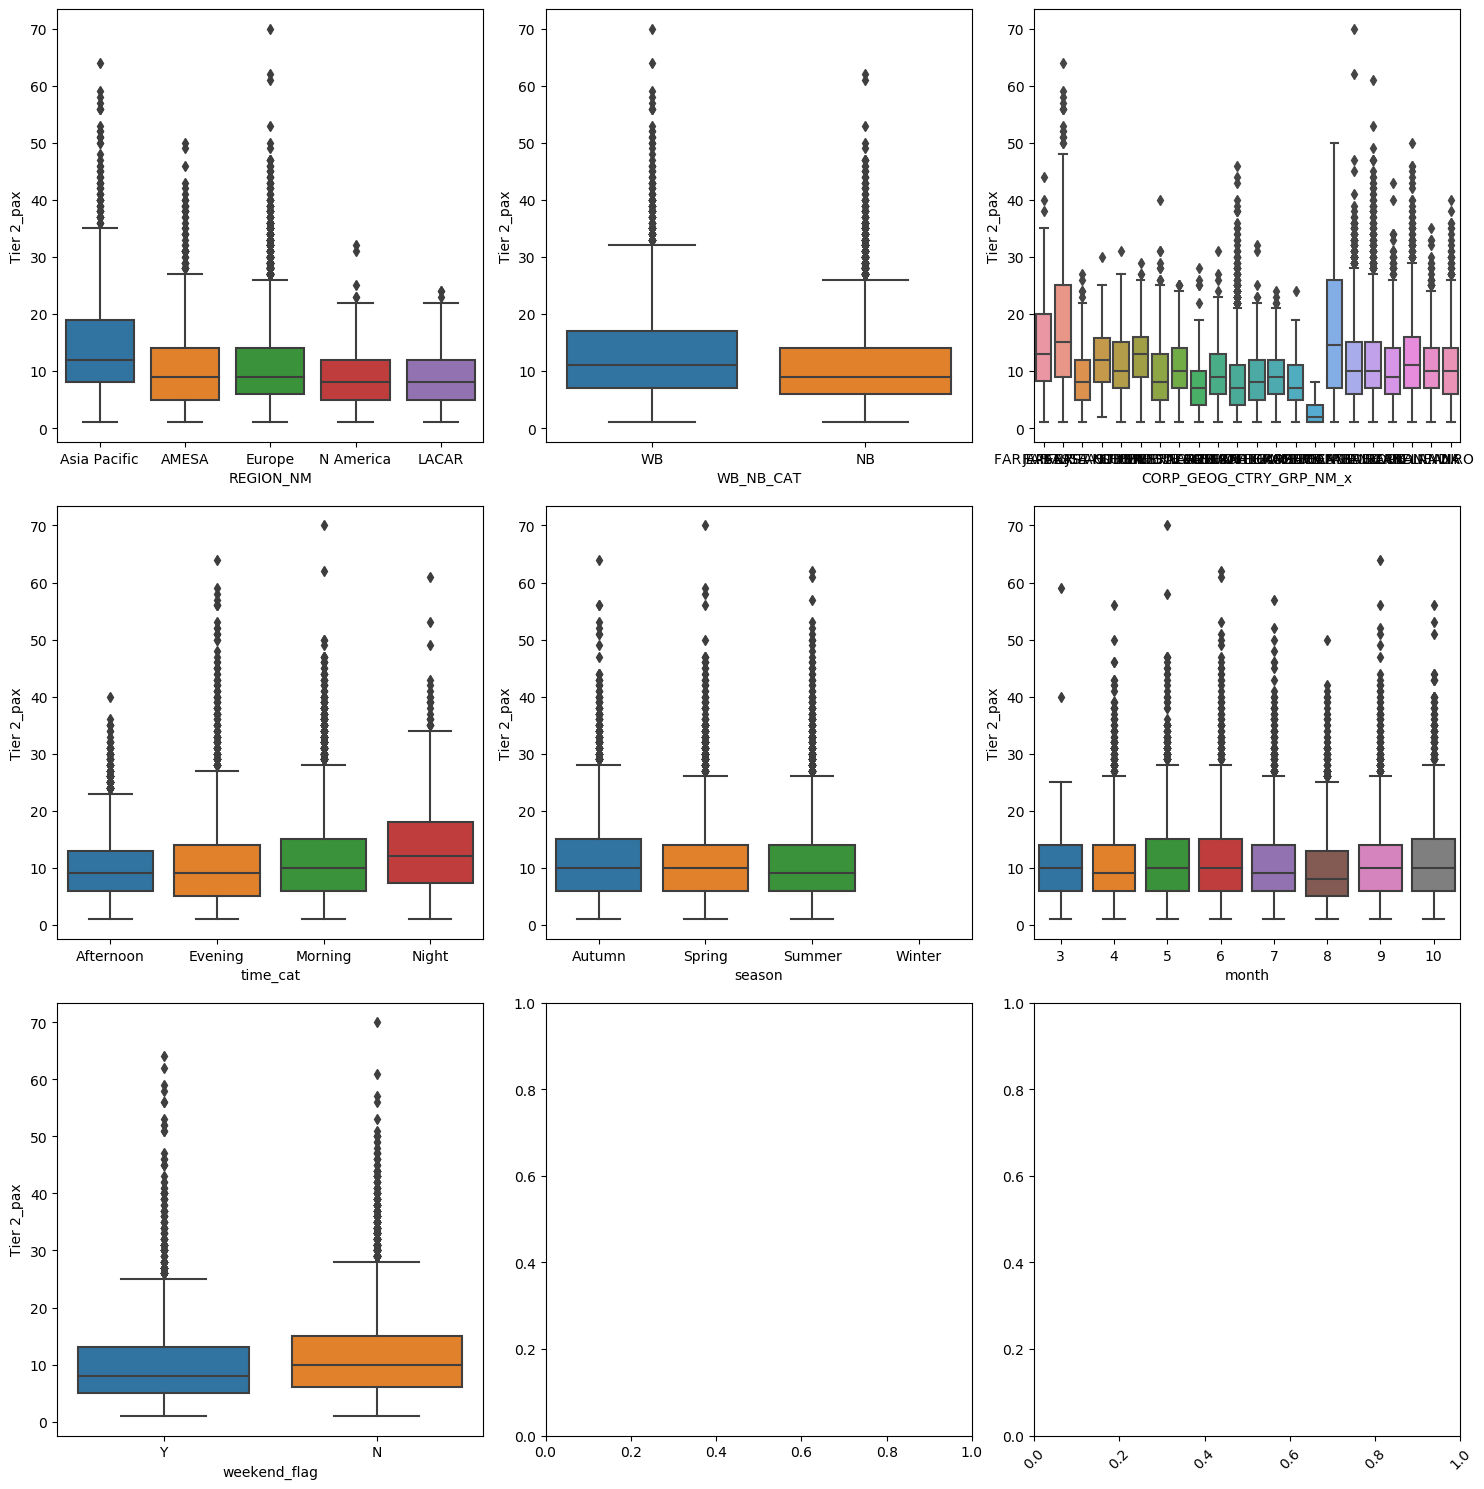

In [32]:
boxplot_cat(cat_feat, df_flight, 'Tier 2_pax')

## Machine Learning

###### To understand variables that are influential in the final prediction

In [81]:
df = df_flight[:]

In [82]:
# dtypes

df.dtypes

OPERATING_AIRLINE_CD               object
OPERATING_FLT_NO                    int64
GMT_UPLIFT_DT              datetime64[ns]
GMT_PLND_DEP_TS            datetime64[ns]
GMT_ACT_DEP_TS             datetime64[ns]
UPLIFT_STN_CD                      object
DISCHARGE_STN_CD                   object
CORP_GEOG_CTRY_GRP_NM_x            object
REGION_NM                          object
WB_NB_CAT                          object
IATA_AC_TYP_CD                     object
capital                            object
FIRST_SEATS_QTY                   float64
CLUB_SEATS_QTY                    float64
PREM_ECONOMY_SEATS_QTY            float64
ECONOMY_SEATS_QTY                 float64
COUNTRY_NM_x                       object
total_pax                           int64
Tier 2_pax                        float64
Tier 3_pax                        float64
Tier 1_pax                        float64
Not eligible_pax                  float64
time_cat                         category
season                           c

In [83]:
# Find the number of missing values
df.isnull().sum()

OPERATING_AIRLINE_CD       0
OPERATING_FLT_NO           0
GMT_UPLIFT_DT              0
GMT_PLND_DEP_TS            0
GMT_ACT_DEP_TS             0
UPLIFT_STN_CD              0
DISCHARGE_STN_CD           0
CORP_GEOG_CTRY_GRP_NM_x    0
REGION_NM                  0
WB_NB_CAT                  0
IATA_AC_TYP_CD             0
capital                    0
FIRST_SEATS_QTY            0
CLUB_SEATS_QTY             0
PREM_ECONOMY_SEATS_QTY     0
ECONOMY_SEATS_QTY          0
COUNTRY_NM_x               0
total_pax                  0
Tier 2_pax                 0
Tier 3_pax                 0
Tier 1_pax                 0
Not eligible_pax           0
time_cat                   0
season                     0
weekend_flag               0
month                      0
day_of_week                0
NB_WB_NEW                  0
Domestic Flag              0
Total Seats                0
dtype: int64

The missing data in Tier pax columns are due to the fact that those airlines have no passengers in that tier and therefore has null values. We can easily solve this by filling it with 0.

In [84]:
df[['Tier 2_pax','Tier 3_pax','Tier 1_pax','Not eligible_pax']] = df[['Tier 2_pax','Tier 3_pax','Tier 1_pax','Not eligible_pax']].fillna(0)

In [85]:
# Total count of missing values
df.isnull().sum().sum()

0

In [86]:
df.head(2)

,OPERATING_AIRLINE_CD,OPERATING_FLT_NO,GMT_UPLIFT_DT,GMT_PLND_DEP_TS,GMT_ACT_DEP_TS,UPLIFT_STN_CD,DISCHARGE_STN_CD,CORP_GEOG_CTRY_GRP_NM_x,REGION_NM,WB_NB_CAT,IATA_AC_TYP_CD,capital,FIRST_SEATS_QTY,CLUB_SEATS_QTY,PREM_ECONOMY_SEATS_QTY,ECONOMY_SEATS_QTY,COUNTRY_NM_x,total_pax,Tier 2_pax,Tier 3_pax,Tier 1_pax,Not eligible_pax,time_cat,season,weekend_flag,month,day_of_week,NB_WB_NEW,Domestic Flag,Total Seats
0,BA,5,2019-03-31,2019-03-31 14:45:00,2019-03-31 14:51:00,LHR,NRT,JAPAN,Asia Pacific,WB,789,Tokyo,8.0,42.0,39.0,127.0,Japan,241,15.0,47.0,10.0,169.0,Afternoon,Spring,Y,3,6,WB w F,N,216.0
1,BA,5,2019-04-01,2019-04-01 14:45:00,2019-04-01 14:54:00,LHR,NRT,JAPAN,Asia Pacific,WB,789,Tokyo,8.0,42.0,39.0,127.0,Japan,225,7.0,43.0,13.0,162.0,Afternoon,Spring,N,4,0,WB w F,N,216.0


In [92]:
cat_feat = ['REGION_NM','NB_WB_NEW','Domestic Flag','time_cat','day_of_week']
num_feat = ['Total Seats']

y = df['Tier 1_pax']
X = df[cat_feat]

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

ohs = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
X_train_adj = ohs.fit_transform(X_train)

lg = LinearRegression()
lg.fit(X_train_adj, y_train)

In [ ]:
cv = cross_validate_score()